In [83]:
import numpy as np
CONSTS = {
    'R': 1.0,
    'CENTER': np.array([1.2, 1.2, 1.2]),
    'N': int(10e5)
}

# Sphere Volume

In [77]:
from numba import jit

## SEED
np.random.seed = 42

def sphere_volume(R:float) -> float:
    return (4/3)*np.pi*R*R*R

@jit(nopython=True)
def sphere_volume_MC(R:float,center:np.ndarray[float] ,N:int) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    sqaure_vol:float = 8*R*R*R
    sum:float = 0.0
    sum_of_squares:float = 0.0

    step = np.zeros(int(N/100))
    expected = np.zeros(int(N/100))
    variance = np.zeros(int(N/100))

    for i in range(1, N + 1):
        # Random Point
        new_point = np.random.uniform(-R, R, size=3) + center

        # result
        dist_sq = np.sum((new_point - center)**2, axis=0)
        multiplyer = 1.0 if dist_sq <= R*R else 0.0

        # Sums
        sum += sqaure_vol * multiplyer
        sum_of_squares += (sqaure_vol * multiplyer)*(sqaure_vol * multiplyer)

        # Checkpoints
        if i%100==0:
            idx = int(i/100) - 1
            step[idx] = i
            expected[idx] = sum/i
            variance[idx] = sum_of_squares/i - (sum/i)*(sum/i)

    std = np.sqrt(variance)
    return step, expected, std



## Results

Błąd Oszacowania = 0.0018977952136092213


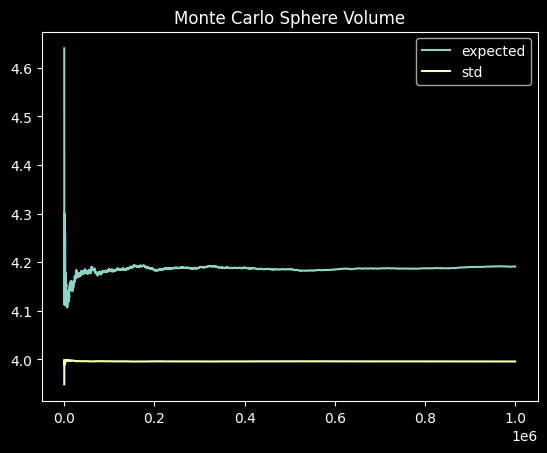

In [80]:
import matplotlib.pyplot as plt

step, expected, std = sphere_volume_MC(CONSTS['R'],CONSTS['CENTER'] ,CONSTS['N'])
error = np.abs(expected[-1] - sphere_volume(CONSTS['R']))
print(f'Błąd Oszacowania = {error}')

plt.plot(step,expected,label='expected')
plt.plot(step,std, label='std')
plt.legend()
plt.title('Monte Carlo Sphere Volume')
plt.show()

# Moment of Interia

In [ ]:
def sphere_interia(R:float) -> float:
    return (4/3)*np.pi*R*R*R

@jit(nopython=True)
def sphere_volume_MC(R:float,center:np.ndarray[float] ,N:int) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    sqaure_vol:float = 8*R*R*R
    sum:float = 0.0
    sum_of_squares:float = 0.0

    step = np.zeros(int(N/100))
    expected = np.zeros(int(N/100))
    variance = np.zeros(int(N/100))

    for i in range(1, N + 1):
        # Random Point
        new_point = np.random.uniform(-R, R, size=3) + center

        # result
        dist_sq = np.sum((new_point - center)**2, axis=0)
        multiplyer = 1.0 if dist_sq <= R*R else 0.0

        # Sums
        sum += sqaure_vol * multiplyer
        sum_of_squares += (sqaure_vol * multiplyer)*(sqaure_vol * multiplyer)

        # Checkpoints
        if i%100==0:
            idx = int(i/100) - 1
            step[idx] = i
            expected[idx] = sum/i
            variance[idx] = sum_of_squares/i - (sum/i)*(sum/i)

    std = np.sqrt(variance)
    return step, expected, std

